In [1]:
import os
mingw_path = 'C:\Program Files\mingw-w64\x86_64-6.2.0-posix-seh-rt_v5-rev1\mingw64\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [119]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
import operator
from sklearn.svm import SVC

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.cross_validation import train_test_split

# bagging
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [3]:
limit_rows   = 7000000
train_df = pd.read_csv("train_encoded.csv", nrows=limit_rows)

#reader = pd.read_csv('train_ver2.csv', chunksize=100000, header=0)
#train_df = pd.concat([chunk for chunk in reader])

unique_ids   = pd.Series(train_df["ncodpers"].unique())
limit_people = 1.2e4
unique_id    = unique_ids.sample(n=limit_people)
train_df     = train_df[train_df.ncodpers.isin(unique_id)]

C:\Users\prill\Anaconda2\lib\site-packages\pandas\core\generic.py:2569: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  locs = rs.choice(axis_length, size=n, replace=replace, p=weights)


In [4]:
train_df.head()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,fecha_dato_month,fecha_dato_year,month_int,fecha_alta_month,fecha_alta_year,fecha_alta_day,fecha_alta_month_int
83,1050514,0,0,1,28,0,35,1,1,1,...,0,0,0,1,0,1,8,-3,10,8
353,1050289,0,0,0,33,0,35,1,1,0,...,0,0,0,1,0,1,8,-3,10,8
401,1050088,0,0,1,22,0,35,1,1,0,...,0,0,0,1,0,1,8,-3,10,8
448,1050167,0,0,0,31,0,35,1,1,1,...,0,0,0,1,0,1,8,-3,10,8
481,1050400,0,0,1,24,0,35,1,1,1,...,0,0,0,1,0,1,8,-3,10,8


In [5]:
test_df = pd.read_csv("test_encoded.csv")
test_df.head()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,ind_actividad_cliente,renta,segmento,fecha_dato_month,fecha_dato_year,month_int,fecha_alta_month,fecha_alta_year,fecha_alta_day,fecha_alta_month_int
0,15889,3,0,0,56,0,256,1,1,0,...,1,326124.906250,1,6,1,18,1,-20,16,13
1,1170544,0,0,1,36,0,34,1,1,1,...,0,-2.000000,2,6,1,18,8,-2,28,20
2,1170545,0,0,0,22,0,34,1,1,0,...,1,-2.000000,3,6,1,18,8,-2,28,20
3,1170547,0,0,1,22,0,34,1,1,1,...,0,148402.984375,3,6,1,18,8,-2,28,20
4,1170548,0,0,1,22,0,34,1,1,1,...,0,106885.796875,3,6,1,18,8,-2,28,20


## 1. Data Cleaning

In [6]:
train_df.isin([-1]).any()

ncodpers                 False
ind_empleado              True
pais_residencia          False
sexo                      True
age                      False
ind_nuevo                 True
antiguedad                True
indrel                    True
indrel_1mes               True
tiprel_1mes               True
indresi                   True
indext                    True
conyuemp                  True
canal_entrada            False
indfall                   True
tipodom                   True
cod_prov                  True
ind_actividad_cliente     True
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco_fin_ult1        False
ind_deme_fin_ult1        False
ind_dela_fin_ult1        False
ind_ecue

In [7]:
test_df.isin([-1]).any()

ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                      True
age                      False
ind_nuevo                False
antiguedad               False
indrel                   False
indrel_1mes               True
tiprel_1mes               True
indresi                  False
indext                   False
conyuemp                  True
canal_entrada            False
indfall                  False
tipodom                  False
cod_prov                  True
ind_actividad_cliente    False
renta                    False
segmento                  True
fecha_dato_month         False
fecha_dato_year          False
month_int                False
fecha_alta_month         False
fecha_alta_year           True
fecha_alta_day           False
fecha_alta_month_int     False
dtype: bool

### ind_actividad_cliente
Activity index (1, active customer; 0, inactive customer)  
should be conducted at the very fist step

In [8]:
train_df.ind_actividad_cliente.value_counts()

 0    47824
 1    44725
-1      332
Name: ind_actividad_cliente, dtype: int64

In [9]:
train_df.ind_actividad_cliente.isin([-1]).sum()

332

these entities should be excluded from the model.

In [10]:
train_df = train_df[train_df.ind_actividad_cliente != -1]
test_df = test_df[test_df.ind_actividad_cliente != -1]

### ind_nuevo
 which indicates whether a customer is new or not

In [11]:
train_df["ind_nuevo"].unique()

array([0, 1], dtype=int64)

In [12]:
train_df["ind_nuevo"].isin([-1]).sum()

0

Let's see if we can fill in missing values by looking how many months of history these customers have.

In [13]:
months_active = train_df.loc[train_df["ind_nuevo"].isin([-1]),:].groupby("ncodpers", sort=False).size()
months_active.max()

nan

Looks like these are all new customers, so replace accordingly.

In [14]:
train_df.ix[train_df["ind_nuevo"].isin([-1]),"ind_nuevo"] = 1

### antiguedad
Customer seniority (in months)

In [15]:
train_df["antiguedad"].isin([-1]).sum()

0

same as ind_nuevo. Let's see if those are same customers.

In [16]:
train_df.ix[train_df["antiguedad"].isin([-1]),"ind_nuevo"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: ind_nuevo, dtype: float64

same customers. Let's give them minimum seniority.

In [17]:
train_df.ix[train_df["antiguedad"].isin([-1]),"antiguedad"] = train_df["antiguedad"].min()
train_df.ix[train_df["antiguedad"].isin([-2]),"antiguedad"] = train_df["antiguedad"].min()

### fetcha_alta
Same entries don't have the date they joined the company.
- missing values are converted as below when data are squeezed  
DF['fecha_alta'] = DF['fecha_alta'].map(lambda x: '2020-00-00' if x == -1 else x)  
DF['fecha_alta_month'] = DF['fecha_alta'].map(lambda x: int(x[5:7])).astype(np.int8)  
DF['fecha_alta_year'] = DF['fecha_alta'].map(lambda x: int(x[0:4]) - 2015).astype(np.int8)  
DF['fecha_alta_day'] = DF['fecha_alta'].map(lambda x: int(x[8:10])).astype(np.int8)  
DF['fecha_alta_motnh_int'] = (DF['fecha_alta_month'] + 12 * DF['fecha_dato_year']).astype(np.int8)


In [18]:
train_df["fecha_alta_month"].isin([00]).sum()

0

filling missing values with medians respectively.

In [19]:
# fecha_alta_month
monthes = train_df.ix[:,"fecha_alta_month"].sort_values().reset_index()
median_month = int(np.median(monthes))
train_df.ix[train_df.fecha_alta_month.isin([-1]), "fecha_alta_month"] = monthes.ix[median_month, "fecha_alta_month"]
# fecha_alta_day
days = train_df.ix[:,"fecha_alta_day"].sort_values().reset_index()
median_day = int(np.median(days))
train_df.ix[train_df.fecha_alta_day.isin([-1]), "fecha_alta_day"] = days.ix[median_day, "fecha_alta_day"]
# fecha_alta_year
years = train_df.ix[:,"fecha_alta_year"].sort_values().reset_index()
median_year = int(np.median(years))
train_df.ix[train_df.fecha_alta_year.isin([-1]), "fecha_alta_year"] = years.ix[median_year, "fecha_alta_year"]
# fecha_alta_month_int
month_int = train_df.ix[:,"fecha_alta_month_int"].sort_values().reset_index()
median_month_int = int(np.median(month_int))
train_df.ix[train_df.fecha_alta_month_int.isin([-1]), "fecha_alta_month_int"] = month_int.ix[median_month_int, "fecha_alta_month_int"]

### indrel
1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)

In [20]:
train_df["indrel"].unique()

array([1, 2], dtype=int64)

In [21]:
train_df["indrel"].isin([-1]).sum()

0

In [22]:
train_df["indrel"].value_counts()

1    92374
2      175
Name: indrel, dtype: int64

filling with the most frequent values

In [23]:
train_df.ix[train_df.indrel.isin([-1]),"indrel"] = 1

### tipodom
Addres type. 1, primary address

In [24]:
train_df["tipodom"].value_counts()

1    92549
Name: tipodom, dtype: int64

doens't seem to be meaningful. so drop it.

In [25]:
train_df.drop(["tipodom"],axis=1,inplace=True)
test_df.drop(["tipodom"],axis=1,inplace=True)

### age

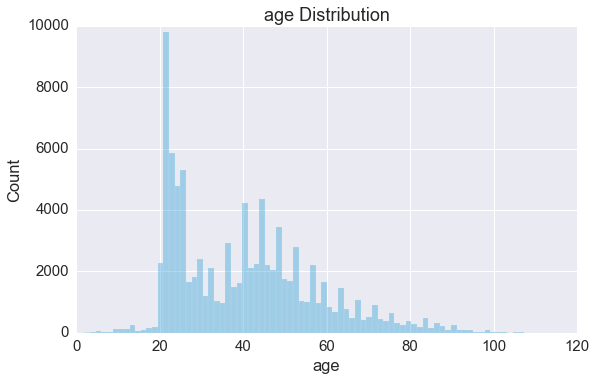

In [26]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style('darkgrid')
    sns.distplot(train_df["age"], bins=80, kde=False)
    sns.plt.title("age Distribution")
    plt.ylabel("Count")

In [27]:
train_df.ix[(train_df.age > -2)&(train_df.age < 18),"age"]  = train_df.ix[(train_df.age >= 18) & (train_df.age <= 30),"age"].mean()
train_df.ix[train_df.age > 100,"age"] = train_df.ix[(train_df.age >= 30) & (train_df.age <= 100),"age"].mean()
train_df.ix[train_df["age"]==-2,"age"] = train_df["age"].mean()
train_df["age"] = train_df["age"].astype(int)

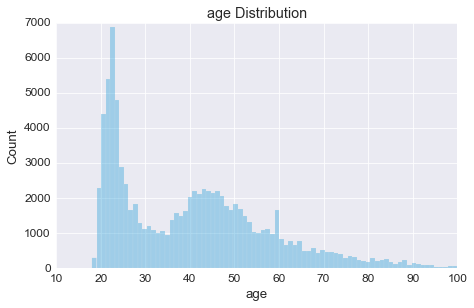

In [28]:
with sns.plotting_context("paper",font_scale=1.5):
    sns.set_style('darkgrid')
    sns.distplot(train_df["age"], bins=80, kde=False)
    sns.plt.title("age Distribution")
    plt.ylabel("Count")

### cod_prov
Province code (customer's address)

In [29]:
train_df.cod_prov.isin([-1]).sum()

407

In [30]:
test_df.cod_prov.isin([-1]).sum()

3996

In [31]:
train_df.ix[train_df.cod_prov.isin([-1]),"cod_prov"] = train_df.cod_prov.median()
test_df.ix[test_df.cod_prov.isin([-1]),"cod_prov"] = test_df.cod_prov.median()

### renta
: gross income

In [32]:
train_df.renta[train_df.renta==-1].count()

16200

In [33]:
train_df.renta.isnull().sum()

0

In [34]:
test_df.renta.isin([-1]).sum()

0

Here is a feature that is missing a lot of values. Filling missing values with a median might not be accurate.  
let's take a look at the median income by region

In [35]:
incomes = train_df.ix[train_df.renta!=(-1 or NAN),:].groupby("cod_prov").agg({"renta":{"MedianIncome":np.median}})
incomes.sort_values(by=("renta","MedianIncome"),inplace=True)
incomes.reset_index(inplace=True)
incomes.cod_prov = incomes.cod_prov.astype("category", categories=[i for i in train_df.cod_prov.unique()],ordered=False)
incomes.head()

,cod_prov,renta
,,MedianIncome
0,6.0,57374.460938
1,10.0,59625.300781
2,27.0,61529.101562
3,13.0,61808.761719
4,5.0,63724.859375


(40000, 180000)

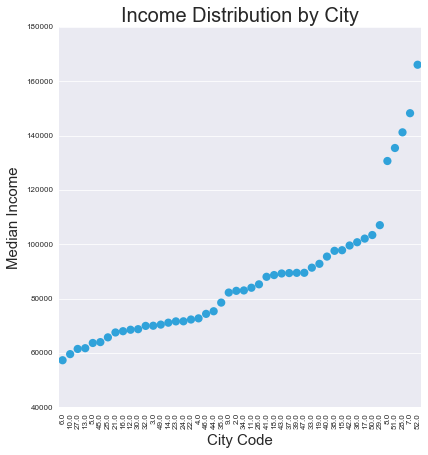

In [36]:
with sns.plotting_context("paper"):
    sns.set_style("darkgrid")
    sns.factorplot(x="cod_prov", y=("renta","MedianIncome"), data=incomes, size=6, linestyles="None", order=(i for i in incomes.cod_prov))

plt.title("Income Distribution by City",size=20)

plt.xticks(rotation=90)
plt.xlabel("City Code",size=15)

plt.ylabel("Median Income",size=15)
plt.ylim(40000,180000)

In [37]:
grouped = train_df.groupby("cod_prov").agg({"renta":lambda x: x.median()}).reset_index()
new_incomes = pd.merge(train_df,grouped,how="inner",on="cod_prov").ix[:, ["cod_prov","renta_y"]]
new_incomes = new_incomes.rename(columns={"renta_y":"renta"}).sort_values("renta").sort_values("cod_prov")
train_df.sort_values("cod_prov",inplace=True)
train_df = train_df.reset_index()
new_incomes = new_incomes.reset_index()

grouped2 = test_df.groupby("cod_prov").agg({"renta":lambda x: x.median()}).reset_index()
new_incomes2 = pd.merge(test_df,grouped,how="inner",on="cod_prov").ix[:, ["cod_prov","renta_y"]]
new_incomes2 = new_incomes2.rename(columns={"renta_y":"renta"}).sort_values("renta").sort_values("cod_prov")
test_df.sort_values("cod_prov",inplace=True)
test_df = test_df.reset_index()
new_incomes2 = new_incomes2.reset_index()

In [38]:
train_df.ix[train_df.renta.isin([-1]) + train_df.renta.isnull(),"renta"] \
= new_incomes.ix[train_df.renta.isin([-1]) + train_df.renta.isnull(),"renta"].reset_index()
train_df.ix[train_df.renta.isin([-1]) + train_df.renta.isnull(),"renta"] \
= train_df.ix[train_df.renta.isin([not -1]) + train_df.renta.notnull(),"renta"].median()

test_df.ix[test_df.renta.isin([-1]) + test_df.renta.isnull(),"renta"] \
= new_incomes2.ix[test_df.renta.isin([-1]) + test_df.renta.isnull(),"renta"].reset_index()
test_df.ix[test_df.renta.isin([-1]) + test_df.renta.isnull(),"renta"] \
= test_df.ix[test_df.renta.isin([not -1]) + test_df.renta.notnull(),"renta"].median()

C:\Users\prill\Anaconda2\lib\site-packages\pandas\computation\expressions.py:181: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [39]:
train_df["renta"].isnull().sum()

0

In [40]:
train_df["renta"].isin([-1]).sum()

0

### left features
There are many categorical features left to be cleaned. First, let's take a look at them.

In [41]:
train_df.isin([-1]).any()

index                    False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                     False
age                      False
ind_nuevo                False
antiguedad               False
indrel                   False
indrel_1mes               True
tiprel_1mes               True
indresi                  False
indext                   False
conyuemp                  True
canal_entrada            False
indfall                  False
cod_prov                 False
ind_actividad_cliente    False
renta                    False
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco_fin_ult1        False
ind_deme_fin_ult1        False
ind_dela_fin_ult1        False
ind_ecue

In [42]:
missing_features = ["indrel_1mes", "tiprel_1mes", "conyuemp", "segmento", "ind_nomina_ult1", "ind_nom_pens_ult1"]
for col in missing_features:
    print("Unique values for {0}:\n{1}\n".format(col,train_df[col].unique()))

Unique values for indrel_1mes:
[ 1 -1  3 -2  2  4]

Unique values for tiprel_1mes:
[ 0  1 -1  2  4]

Unique values for conyuemp:
[-1  0]

Unique values for segmento:
[ 2  1  3 -1]

Unique values for ind_nomina_ult1:
[ 0  1 -1]

Unique values for ind_nom_pens_ult1:
[ 0  1 -1]



conyuemp has one type of values to drop it.

In [43]:
train_df.drop(["conyuemp"], axis=1, inplace=True)
test_df.drop(["conyuemp"], axis=1, inplace=True)

### indrel_1mes

In [44]:
train_df["indrel_1mes"].value_counts()

 1    91503
-1     1019
 3       16
-2        5
 2        4
 4        2
Name: indrel_1mes, dtype: int64

In [45]:
test_df["indrel_1mes"].value_counts()

 1    929565
 3        27
-1        23
Name: indrel_1mes, dtype: int64

filling missing values with the most frequent value, which is 1.

In [46]:
train_df.ix[train_df.indrel_1mes.isin([-1]), "indrel_1mes"] = 1
test_df.ix[test_df.indrel_1mes.isin([-1]), "indrel_1mes"] = 1

### tiprel_1mes
Customer relation type at the beginning of the month, 0 (active), 1 (inactive), 2 (former customer), 4 (Potential)

In [47]:
train_df["tiprel_1mes"].value_counts()

 1    47293
 0    44214
-1     1019
 2       18
 4        5
Name: tiprel_1mes, dtype: int64

In [48]:
test_df['tiprel_1mes'].value_counts()

 1    535943
 0    393622
 2        27
-1        23
Name: tiprel_1mes, dtype: int64

In [49]:
train_df.ix[train_df.tiprel_1mes.isin([-1]), "tiprel_1mes"] = 0
test_df.ix[test_df.tiprel_1mes.isin([-1]), "tiprel_1mes"] = 0

### segmento
segmentation: 01 - VIP, 02 - Individuals 03 - college graduated

In [50]:
train_df["segmento"].value_counts()

 2    54397
 3    32745
 1     4154
-1     1253
Name: segmento, dtype: int64

In [51]:
test_df["segmento"].value_counts()

 2    545378
 3    346028
 1     35961
-1      2248
Name: segmento, dtype: int64

In [52]:
train_df.ix[train_df.segmento.isin([-1]), "segmento"] = 2
test_df.ix[test_df.segmento.isin([-1]), "segmento"] = 2

### ind_nomina_ult1, ind_nom_pens_ult1

In [53]:
train_df["ind_nomina_ult1"].value_counts()

 0    87204
 1     5344
-1        1
Name: ind_nomina_ult1, dtype: int64

In [54]:
train_df["ind_nom_pens_ult1"].value_counts()

 0    86806
 1     5742
-1        1
Name: ind_nom_pens_ult1, dtype: int64

The numer of missing values is very small. just replace them with the most common value.

In [55]:
train_df.ix[train_df.ind_nomina_ult1.isin([-1]), "ind_nomina_ult1"] = 0
train_df.ix[train_df.ind_nom_pens_ult1.isin([-1]), "ind_nom_pens_ult1"] = 0

In [56]:
train_df.isin([-1]).any().sum()

0

In [57]:
train_df.isnull().any()

index                    False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                     False
age                      False
ind_nuevo                False
antiguedad               False
indrel                   False
indrel_1mes              False
tiprel_1mes              False
indresi                  False
indext                   False
canal_entrada            False
indfall                  False
cod_prov                 False
ind_actividad_cliente    False
renta                    False
segmento                 False
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco_fin_ult1        False
ind_deme_fin_ult1        False
ind_dela_fin_ult1        False
ind_ecue_fin_ult1        False
ind_fond

### sexo

In [58]:
train_df["sexo"].value_counts()

0    51180
1    41369
Name: sexo, dtype: int64

In [59]:
test_df["sexo"].value_counts()

 0    504515
 1    425095
-1         5
Name: sexo, dtype: int64

In [60]:
train_df.ix[train_df.sexo.isin([-1]), "sexo"] = 0
test_df.ix[test_df.sexo.isin([-1]), "sexo"] = 0

double check if there any missing values

### preparing for fitting

In [151]:
target_cols = ['ncodpers', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
               'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
               'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
               'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
               'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
               'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
               'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
               'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

feature_cols = ["ind_empleado","pais_residencia","sexo", "age", "ind_nuevo", "antiguedad",
                "indrel","indrel_1mes","tiprel_1mes","indresi","indext","canal_entrada","indfall","cod_prov","ind_actividad_cliente",
                "renta","segmento","fecha_dato_month","fecha_dato_year","month_int","fecha_alta_month","fecha_alta_year","fecha_alta_day",
                "fecha_alta_month_int"]

I got warning message when fitting data into Random Forest.(Input contains NaN, infinity or a value too large for dtype('float32').)
I look into data's info as below.

In [62]:
train_df.describe()

,index,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,...,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,fecha_dato_month,fecha_dato_year,month_int,fecha_alta_month,fecha_alta_year,fecha_alta_day,fecha_alta_month_int
count,9.254900e+04,9.254900e+04,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,...,92549.000000,92549.000000,92549.000000,92549.000000,92549.0,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000
mean,3.506967e+06,7.988560e+05,0.001599,0.105339,0.446996,40.453273,0.037656,81.002971,1.001891,1.000292,...,0.057742,0.062043,0.132892,5.787323,0.0,5.787323,7.397562,-9.382867,15.821468,7.397562
std,2.020898e+06,4.211841e+05,0.060233,2.061739,0.497185,17.029479,0.190363,66.380060,0.043443,0.037622,...,0.233257,0.241235,0.339460,2.855817,0.0,2.855817,3.267457,6.513818,8.894133,3.267457
min,8.300000e+01,1.592400e+04,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,-2.000000,...,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,1.000000,-20.000000,1.000000,1.000000
25%,1.756843e+06,4.139790e+05,0.000000,0.000000,0.000000,24.000000,0.000000,23.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,3.000000,0.0,3.000000,5.000000,-14.000000,8.000000,5.000000
50%,3.516178e+06,9.129750e+05,0.000000,0.000000,0.000000,39.000000,0.000000,48.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,6.000000,0.0,6.000000,8.000000,-9.000000,16.000000,8.000000
75%,5.261196e+06,1.161081e+06,0.000000,0.000000,1.000000,51.000000,0.000000,140.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,8.000000,0.0,8.000000,10.000000,-3.000000,24.000000,10.000000
max,6.999961e+06,1.495415e+06,3.000000,93.000000,1.000000,100.000000,1.000000,249.000000,2.000000,4.000000,...,1.000000,1.000000,1.000000,10.000000,0.0,10.000000,12.000000,0.000000,31.000000,12.000000


In [63]:
train_df.ix[:,'tiprel_1mes':'ind_nomina_ult1'].describe()

,tiprel_1mes,indresi,indext,canal_entrada,indfall,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,...,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1
count,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,9.254900e+04,92549.000000,92549.0,...,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000
mean,0.511610,0.995602,0.045100,9.366120,0.002528,26.448022,0.483258,1.281819e+05,2.308928,0.0,...,0.084485,0.021589,0.006861,0.010211,0.002410,0.054242,0.049282,0.028190,0.003036,0.057742
std,0.500904,0.066169,0.207526,22.088076,0.050220,12.747415,0.499722,1.795710e+05,0.550694,0.0,...,0.278115,0.145337,0.082548,0.100532,0.049028,0.226495,0.216457,0.165518,0.055019,0.233257
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,7.143540e+03,1.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000,0.000000,15.000000,0.000000,7.303491e+04,2.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,4.000000,0.000000,28.000000,0.000000,9.987369e+04,2.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,5.000000,0.000000,33.000000,1.000000,1.418798e+05,3.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,1.000000,1.000000,157.000000,1.000000,52.000000,1.000000,1.185786e+07,3.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
train_df.ix[:,'renta':'ind_ecue_fin_ult1'].describe()

,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1
count,9.254900e+04,92549.000000,92549.0,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000,92549.000000
mean,1.281819e+05,2.308928,0.0,0.000065,0.705108,0.000443,0.082659,0.012685,0.010340,0.148667,0.048785,0.002604,0.002917,0.048785,0.084485
std,1.795710e+05,0.550694,0.0,0.008052,0.455997,0.021043,0.275367,0.111912,0.101162,0.355762,0.215419,0.050963,0.053934,0.215419,0.278115
min,7.143540e+03,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.303491e+04,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.987369e+04,2.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.418798e+05,3.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.185786e+07,3.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


resize data

In [65]:
def resize_data(DF,is_DF):
    DF['ncodpers'] = DF['ncodpers'].astype(np.int32)
    DF['renta'] = DF['renta'].astype(np.float32)
    DF['indrel'] = DF['indrel'].astype(np.int8)
    DF['ind_empleado'] = DF['ind_empleado'].astype(np.int8)
    DF['sexo'] = DF['sexo'].astype(np.int8)
    DF['age'] = DF['age'].astype(np.int16)
    DF['ind_nuevo'] = DF['ind_nuevo'].astype(np.int8)
    DF['antiguedad'] = DF['antiguedad'].astype(int)
    DF['antiguedad'] = DF['antiguedad'].astype(np.int16)
    DF['indrel_1mes'] = DF['indrel_1mes'].astype(np.float16)
    DF['indrel_1mes'] = DF['indrel_1mes'].astype(np.int8)
    DF['tiprel_1mes'] = DF['tiprel_1mes'].astype(np.int8)
    DF['indresi'] = DF['indresi'].astype(np.int8)
    DF['indext'] = DF['indext'].astype(np.int8)
    DF['canal_entrada'] = DF['canal_entrada'].astype(np.int16)
    DF['indfall'] = DF['indfall'].astype(np.int8)
    DF['pais_residencia'] = DF['pais_residencia'].astype(np.int8)
    DF['cod_prov'] = DF['cod_prov'].astype(np.int8)
    DF['ind_actividad_cliente'].astype(np.int8)
    DF['fecha_dato_month'] = DF['fecha_dato_month'].astype(np.int8)
    DF['fecha_dato_year'] = DF['fecha_dato_year'].astype(np.int8)
    DF['month_int'] = DF['month_int'].astype(np.int8)

    DF['fecha_alta_month'] = DF['fecha_alta_month'].astype(np.int8)
    DF['fecha_alta_year'] = DF['fecha_alta_year'].astype(np.int8)
    DF['fecha_alta_day'] = DF['fecha_alta_day'].astype(np.int8)
    DF['fecha_alta_month_int'] = DF['fecha_alta_month_int'].astype(np.int8)

    DF['segmento'] = DF['segmento'].astype(np.int8)

    for col in target_cols:
        if is_DF:
            DF[col] = DF[col].astype(np.int8)

    return DF

resize_data(train_df, True)
resize_data(test_df, False)

,index,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,...,ind_actividad_cliente,renta,segmento,fecha_dato_month,fecha_dato_year,month_int,fecha_alta_month,fecha_alta_year,fecha_alta_day,fecha_alta_month_int
0,791423,891715,0,0,0,42,0,69,1,1,...,0,-2.000000,2,6,1,18,9,-5,15,21
1,874349,702294,0,0,0,40,0,107,1,1,...,1,-2.000000,2,6,1,18,7,-8,10,19
2,570480,425683,0,0,1,44,0,156,1,1,...,1,-2.000000,2,6,1,18,7,-12,1,19
3,865971,515631,0,0,0,70,0,136,1,1,...,0,-2.000000,2,6,1,18,2,-10,3,14
4,842031,596057,0,0,0,66,0,123,1,1,...,0,-2.000000,2,6,1,18,3,-9,22,15
5,687336,184568,0,0,0,82,0,191,1,1,...,1,-2.000000,2,6,1,18,7,-15,24,19
6,269956,1430713,0,0,0,22,0,10,1,1,...,1,-2.000000,3,6,1,18,8,0,6,20
7,472592,313344,0,0,0,42,0,173,1,1,...,0,-2.000000,2,6,1,18,1,-13,7,13
8,80529,1250706,0,0,0,44,0,27,1,1,...,1,-2.000000,2,6,1,18,3,-1,27,15
9,475725,321548,0,0,0,60,0,160,1,1,...,1,-2.000000,2,6,1,18,1,-13,24,13


In [66]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92517 entries, 0 to 92516
Data columns (total 50 columns):
index                    92517 non-null int64
ncodpers                 92517 non-null int8
ind_empleado             92517 non-null int8
pais_residencia          92517 non-null int8
sexo                     92517 non-null int8
age                      92517 non-null int16
ind_nuevo                92517 non-null int8
antiguedad               92517 non-null int16
indrel                   92517 non-null int8
indrel_1mes              92517 non-null int8
tiprel_1mes              92517 non-null int8
indresi                  92517 non-null int8
indext                   92517 non-null int8
canal_entrada            92517 non-null int16
indfall                  92517 non-null int8
cod_prov                 92517 non-null int8
ind_actividad_cliente    92517 non-null int64
renta                    92517 non-null float32
segmento                 92517 non-null int8
ind_ahor_fin_ult1        925

devide train data set into y_train and x_train.

In [246]:
train_y = DataFrame(data=train_df, columns = target_cols)
print train_y.shape
train_yy = train_y # for feature selection
train_x = DataFrame(data=train_df, columns = feature_cols)
test_x = DataFrame(data=test_df, columns = feature_cols)

last_instance_df = train_y.drop_duplicates('ncodpers', keep='last')
train_y = np.array(train_y.fillna(0)).astype('int')[:,1:]
print(train_y.shape, train_x.shape, test_x.shape)

(92549, 25)
((92549L, 24L), (92549, 24), (929615, 24))


## 2. Feature Selection

In [247]:
X = train_x.values
skb = SelectKBest()
prod_cols = list(train_yy.columns)

In [248]:
d = {}
for p in prod_cols:
    y = np.array(train_df[p])
    fit = skb.fit(X, y)
    l = zip(train_x.columns, np.around(fit.scores_))
    d[p] = sorted(l, key=lambda x: x[1], reverse=True)

In [249]:
ranking = pd.DataFrame(index=train_x.columns,columns=prod_cols)

In [250]:
for p in prod_cols:
    i = 0
    for r in d[p]:
        ranking[p][r[0]] = i
        i += 1

In [251]:
ranking['total'] = ranking.sum(axis=1)

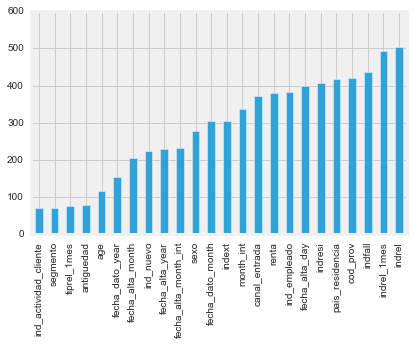

In [252]:
ranking.sort_values('total')
ranking.sort_values('total')['total'].plot(kind='bar')

In [253]:
ranking_df = ranking.total.reset_index()
ranking_df = ranking_df[ranking_df.total > 100]
ranking_df.sort_values("total", ascending=False, inplace=True)
ranking_df

,index,total
6,indrel,503.0
7,indrel_1mes,494.0
12,indfall,436.0
13,cod_prov,420.0
1,pais_residencia,418.0
9,indresi,406.0
22,fecha_alta_day,399.0
0,ind_empleado,383.0
15,renta,381.0
11,canal_entrada,373.0


In [254]:
selected_xs = list(ranking_df["index"])
# drop uneffective features
train_x = DataFrame(data=train_x, columns = selected_xs)
test_x = DataFrame(data=test_x, columns = selected_xs)

del train_yy

In [255]:
print(train_x.shape, test_x.shape)

((92549, 20), (929615, 20))


## 3. Model Fitting

### XGB

convert dataframe to numpy array.  
XGB takes numpy array not dataframe.

In [256]:
train_x = train_x.values
test_x = test_x.values

bulid model

In [257]:
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.5,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'max_depth': 10,
    'min_child_weight': 100,
    'booster': 'gbtree',
    'eval_metric': 'logloss'
    }

preds_test = []

for ind, col in enumerate(train_y.T):
    
    train_y = col
    
    d_train = xgb.DMatrix(train_x, label=train_y)
    d_test = xgb.DMatrix(test_x)

    watchlist = [(d_train, 'train'), (d_valid, 'eval')]

    clf = xgb.train(xgb_params,
                    d_train,
                    300,
                    watchlist,
                    early_stopping_rounds = 50, verbose_eval = False)

    probs_test = clf.predict(d_test)
        
    preds_test.append(probs_test)

preds_at = np.asarray(preds_test)

get last instance dict

In [258]:
last_instance_df = last_instance_df.fillna(0).astype('int')
cust_dict = {}
target_cols2 = np.array(target_cols)[1:]
for ind, row in last_instance_df.iterrows():
    cust = row['ncodpers']
    used_products = set(target_cols2[np.array(row[1:])==1])
    cust_dict[cust] = used_products

creat csv file of prediction for submitting to kaggle.

In [275]:
preds = np.asarray(preds_at).T

In [276]:
preds = np.argsort(preds, axis=1)
preds = np.fliplr(preds)
test_id = np.array(pd.read_csv("test_encoded.csv", usecols=['ncodpers'])['ncodpers'])
final_preds = []
for ind, pred in enumerate(preds):
    cust = test_id[ind]
    top_products = target_cols[pred]
    used_products = cust_dict.get(cust,[])
    new_top_products = []
    for product in top_products:
        if product not in used_products:
            new_top_products.append(product)
        if len(new_top_products) == 7:
            break
    final_preds.append(" ".join(new_top_products))

len(final_preds[0])
len(final_preds)
final_preds[0]

out_df = pd.DataFrame({'ncodpers':test_id, 'added_products':final_preds})
out_df.to_csv('XGBoost.csv', index=False)